# Retraining MobileNet V2 for Person Detection and ESP32 Compatibility


In [386]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import sklearn as skl
import pandas as pd
import seaborn as sns
import cv2
import keras_cv
import albumentations as A



In [387]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Datasets version:", tfds.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", mat.__version__)
print("Scikit-learn version:", skl.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("OpenCV version:", cv2.__version__)
print("keras_cv version:", keras_cv.__version__)
print("a version:", A.__version__)


TensorFlow version: 2.17.0
TensorFlow Datasets version: 4.9.6
Keras version: 3.5.0
NumPy version: 1.26.4
Matplotlib version: 3.7.5
Scikit-learn version: 1.5.2
Pandas version: 2.2.3
Seaborn version: 0.13.2
OpenCV version: 4.10.0
keras_cv version: 0.9.0
a version: 1.4.18


In [388]:
# constants for various parts of the model
IMAGE_CHANNELS = 3

# input image (ie image from esp 32 looks size)
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# pretrained MobileNetV2 model image size
BASE_MODEL_IMAGE_HEIGHT = 96
BASE_MODEL_IMAGE_WIDTH = 96
BASE_MODEL_IMAGE_SHAPE = (BASE_MODEL_IMAGE_HEIGHT, BASE_MODEL_IMAGE_WIDTH, IMAGE_CHANNELS)

# final model input shape (flat)
MODEL_INPUT_SHAPE = (IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH)

BATCH_SIZE = 32

MODEL_SAVE_PATH = './model.keras'
LITE_MODEL_SAVE_PATH = './model.tflite'


## Preparing a Dataset

### Using an Existing Dataset

In [389]:
# Data set file location

# Load the dataset with the specified data directory ~25GB
ds_train, ds_validation = tfds.load('coco/2017', split=['train','validation'])

def augment_image(image, bounding_boxes, class_labels):
    transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.Affine(translate_percent=(0.1, 0.1), p=1),
        A.RandomBrightnessContrast(p=0.2),
        #A.RandomCrop(width=256, height=256, p=0.5),
        # Add more augmentations as needed
    ], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

    transformed = transform(image=image, bboxes=bounding_boxes, class_labels=class_labels)
    print("transformed")
    print(transformed['bboxes'])
    return transformed['image'], transformed['bboxes'], transformed['class_labels']

def random_translate_image_and_label(image, bbox, labels):
    image_np = image
    bounding_boxes = bbox.tolist()
    class_labels = labels.tolist()
    # for i in range(len(bounding_boxes)):
    #     bounding_boxes[i].append(class_labels[i])

    print("bounding_boxes")
    print(image_np.shape)
    print(bounding_boxes)




    augmented_image, augmented_bboxes, augmented_labels = augment_image(image_np, bounding_boxes, class_labels)

    return augmented_image, augmented_bboxes, augmented_labels

def tf_random_translate_image_and_label(example):
    image = example['image']
    bbox = example['objects']['bbox']
    
    print(example['objects'])
    labels = example['objects']['label']

    augmented_image, augmented_bboxes, augmented_labels = tf.numpy_function(
        random_translate_image_and_label, [image, bbox, labels], [tf.uint8, tf.double, tf.double]
    )
# Set the shape of the augmented image and bounding boxes
    augmented_image.set_shape(image.shape)
    augmented_bboxes.set_shape(bbox.shape)
    example['image'] = augmented_image
    example['objects']['bbox'] = augmented_bboxes
    example['objects']['label'] = augmented_labels
    

    return example

ds_train = ds_train.map(tf_random_translate_image_and_label)
ds_validation = ds_validation.map(tf_random_translate_image_and_label)

{'area': <tf.Tensor 'args_3:0' shape=(None,) dtype=int64>, 'bbox': <tf.Tensor 'args_4:0' shape=(None, 4) dtype=float32>, 'id': <tf.Tensor 'args_5:0' shape=(None,) dtype=int64>, 'is_crowd': <tf.Tensor 'args_6:0' shape=(None,) dtype=bool>, 'label': <tf.Tensor 'args_7:0' shape=(None,) dtype=int64>}
{'area': <tf.Tensor 'args_3:0' shape=(None,) dtype=int64>, 'bbox': <tf.Tensor 'args_4:0' shape=(None, 4) dtype=float32>, 'id': <tf.Tensor 'args_5:0' shape=(None,) dtype=int64>, 'is_crowd': <tf.Tensor 'args_6:0' shape=(None,) dtype=bool>, 'label': <tf.Tensor 'args_7:0' shape=(None,) dtype=int64>}


In [390]:

# Define the label for 'person' in the dataset
# The original label is a list of objects classes with bounding boxes
# The label for 'person' in the COCO dataset is 0 there are 80 classes in the COCO dataset
# we will create a new label that is 1 if the object is a person and 0 otherwise

COCO_PERSON_CLASS = 0 
def create_label(example):
    objects = example['objects']
    bbox = objects["bbox"]
    is_crowds = objects["is_crowd"]
    print(bbox)
    y_mins, x_mins, y_maxs, x_maxs = tf.unstack(bbox, axis=-1)

    widths = x_maxs - x_mins
    heights = y_maxs - y_mins
    x_centers = x_mins + (widths / 2)
    y_centers = y_mins + (heights / 2)
    areas = widths * heights

    object_centers = tf.stack([x_centers, y_centers], axis=-1) 

    


    object_labels = example['objects']['label']
    output = {'image': example['image']}

    person_centers_indices = tf.where(tf.logical_and(tf.equal(object_labels, COCO_PERSON_CLASS), tf.logical_not(is_crowds)))
    person_centers = tf.gather_nd(object_centers, person_centers_indices)
    person_count = tf.size(person_centers) // 2  # Each center has 2 coordinates (x, y)

    if tf.size(person_centers) == 0:
        output['label'] = {
            'person':  tf.constant([[0]], dtype=tf.int32),
              'person_center':  tf.random.uniform(shape=[2], minval=0, maxval=1, dtype=tf.float64),
                'person_count': tf.constant([[0]], dtype=tf.int32)}
        return output
    person_areas = tf.gather_nd(areas, person_centers_indices)
    largest_person_index = tf.argmax(person_areas)
    largest_person_center = tf.gather(person_centers,largest_person_index)

    print("person large")
    print(largest_person_center)
    output['label'] = {'person':  tf.constant([[1]], dtype=tf.int32), 'person_center': largest_person_center, 'person_count': person_count}
    return output

def format_image(example):
    # Resize the image
    example["image"] = tf.image.resize(example["image"], [IMAGE_HEIGHT, IMAGE_WIDTH])
    # convert the pixel values to be between 0 and 1
    example["image"] = tf.cast(example["image"], tf.float32) / 255.0
    return example

# flatten image (flat image match the shape of images from the esp32 camera)
def flatten_image(example):
    example["image"] = tf.reshape(example["image"], (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))
    return example
    
# tuple format (Training expects a tuple of (image, label))
def convert_to_tuple(example):
    return (example["image"], example["label"])

def filter_single_person(example):
    return tf.equal(example['label']['person_count'], 1)
def remove_person_count(example):
    example['label'].pop('person_count')
    return example

# Apply the mapping functions to the dataset
ds_train = ds_train.map(create_label)
ds_validation = ds_validation.map(create_label)

# Filter the dataset to include only images with exactly one person
ds_train = ds_train.filter(filter_single_person)
ds_validation = ds_validation.filter(filter_single_person)

# Remove the 'person_count' field from the label
ds_train = ds_train.map(remove_person_count)
ds_validation = ds_validation.map(remove_person_count)

# Continue with the rest of the preprocessing steps
ds_train = ds_train.map(format_image)
ds_validation = ds_validation.map(format_image)
ds_train = ds_train.map(flatten_image)
ds_validation = ds_validation.map(flatten_image)
ds_train = ds_train.map(convert_to_tuple)
ds_validation = ds_validation.map(convert_to_tuple)

Tensor("args_4:0", shape=(None, 4), dtype=float64)
person large
Tensor("cond/GatherV2:0", dtype=float64)
Tensor("args_4:0", shape=(None, 4), dtype=float64)
person large
Tensor("cond/GatherV2:0", dtype=float64)


bounding_boxes
(462, 640, 3)
[[0.5438095331192017, 0.1346406191587448, 0.9865151643753052, 0.33742186427116394], [0.5070779323577881, 0.5178750157356262, 0.8044804930686951, 0.8911250233650208], [0.326493501663208, 0.3697187602519989, 0.6520346403121948, 0.44318750500679016]]
transformed
[[0.6438095331192016, 0.2346406191587448, 1.0, 0.4374218642711639], [0.6070779323577881, 0.6178750157356262, 0.904480493068695, 0.9911250233650207], [0.426493501663208, 0.4697187602519989, 0.7520346403121948, 0.5431875050067901]]
bounding_boxes
(480, 640, 3)
[[0.15716665983200073, 0.19895312190055847, 0.7863749861717224, 0.3883593678474426], [0.1300416737794876, 0.03700000047683716, 0.6031458377838135, 0.22870312631130219], [0.15339583158493042, 0.8033750057220459, 0.559333324432373, 0.8862812519073486], [0.11820833384990692, 0.23720312118530273, 0.25458332896232605, 0.2933281362056732]]
tf.Tensor([[0.         0.         0.         ... 0.3375738  0.32247537 0.3050327 ]], shape=(1, 172800), dtype=float3

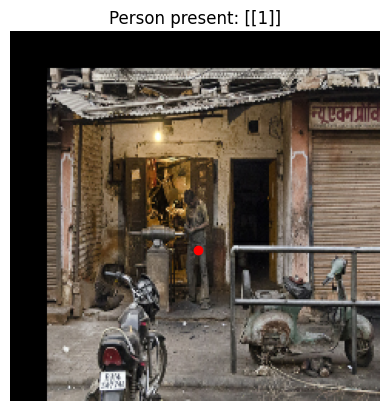

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:9865 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::ParallelMapV2::ParallelMapV2::ParallelMapV2::Filter::Map: Incompatible shapes: [22] vs. [24]
	 [[{{node LogicalAnd}}]] [Op:IteratorGetNext] name: 

bounding_boxes
(424, 640, 3)
[[0.5545754432678223, 0.15589062869548798, 0.7724056839942932, 0.8609218597412109], [0.3086792528629303, 0.4648124873638153, 0.3760141432285309, 0.6180468797683716], [0.5281603932380676, 0.3095781207084656, 0.7004480957984924, 0.4269687533378601], [0.5199764370918274, 0.4460468888282776, 0.6996933817863464, 0.5262500047683716], [0.4428773522377014, 0.5710312724113464, 0.6919811367988586, 0.6501250267028809], [0.5531367659568787, 0.6829843521118164, 0.6240330338478088, 0.7643437385559082], [0.6225707530975342, 0.4463750123977661, 0.6958019137382507, 0.5113593935966492], [0.6187971830368042, 0.29176563024520874, 0.700754702091217, 0.3285312354564667]]
transformed
[[0.6545754432678222, 0.255890628695488, 0.8724056839942932, 0.9609218597412109], [0.4086792528629303, 0.5648124873638153, 0.47601414322853086, 0.7180468797683716], [0.6281603932380676, 0.4095781207084656, 0.8004480957984924, 0.5269687533378601], [0.6199764370918274, 0.5460468888282776, 0.79969338178

In [391]:

# Iterate through the dataset and print an example
for example in ds_train.take(10):
    image, label = example[0], example[1]
    person_present = label['person']
    person_center = label['person_center']
    print(image)
    print(person_present.shape)
    print(person_center.shape)
    print(f"Person present: {person_present.numpy()}")
    print(f"Center: {person_center.numpy()}")

    
    # Display the image using Matplotlib
    plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    plt.title(f"Person present: {person_present}")
    plt.plot(person_center[0] * IMAGE_WIDTH, person_center[1] * IMAGE_HEIGHT, 'ro')
    plt.axis('off')
    plt.show()



In [366]:
#TODO using a batched dataset breaks training?
# ds_train_batched = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# for example in ds_train_batched.take(1):
#     print(example[0].shape)
#     print(example[1].shape)
# print(ds_train_batched)

### Creating Your Own Dataset

In [367]:
# # Define the preprocessing functions
# def load_and_preprocess_image(path):
#     image_string = tf.io.read_file(path)
#     img = tf.io.decode_jpeg(image_string, channels=3)
#     return tf.reshape(tf.image.resize(img, [240, 240]) /255, (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))

# def load_and_preprocess_from_path_labels(path, label):
#     label = tf.reshape( label,(1,1))
#     return load_and_preprocess_image(path), label

# def create_dataset (label_studio_csv, path_to_image_upload_folder, train_val_split = 0.8):
#     # Load the CSV file into a DataFrame
#     df = pd.read_csv(label_studio_csv)

#     # Extract image paths and labels
#     all_image_paths = df['image'].apply(lambda x: x.replace('/data', path_to_image_upload_folder)).tolist()
#     all_image_labels = df['choice'].apply(lambda x: 1 if x == 'person' else 0 ).tolist()
#     ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
#     csv_dataset = ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)
#     # Set the seed for reproducibility

#     # Shuffle the dataset
#     csv_dataset = csv_dataset.shuffle(buffer_size=len(all_image_paths), seed=42, reshuffle_each_iteration=False)
#     # Determine the split sizes
#     dataset_size = len(all_image_paths)
#     train_size = int(train_val_split * dataset_size)
#     train_csv_dataset = csv_dataset.take(train_size)
#     val_csv_dataset = csv_dataset.skip(train_size)
#     return train_csv_dataset, val_csv_dataset

# # make the data set have equal number of each class
# def balance_data_set (ds):

#     # Separate the training dataset into two datasets based on labels
#     dataset_true = ds.filter(lambda image, label: tf.equal(tf.reshape(label, ()), 1))
#     dataset_false = ds.filter(lambda image, label: not tf.equal(tf.reshape(label, ()), 1))

#     # Determine the minimum count of the two labels
#     count_true = dataset_true.reduce(0, lambda x, _: x + 1).numpy()
#     count_false = dataset_false.reduce(0, lambda x, _: x + 1).numpy()
#     min_count = min(count_true, count_false)

#     # Resample the datasets to have the same number of samples for each label
#     dataset_true = dataset_true.take(min_count)
#     dataset_false = dataset_false.take(min_count)

#     # Combine and shuffle the balanced dataset
#     balanced_train_csv_dataset = dataset_true.concatenate(dataset_false)
#     balanced_train_csv_dataset = balanced_train_csv_dataset.shuffle(buffer_size=min_count * 2, seed=42, reshuffle_each_iteration=False)
#     return balanced_train_csv_dataset



In [368]:



# # Define the path to the CSV file
# csv_file_path = 'front_door_label_export.csv'
# path_to_image_upload_folder = 'C:/Users/nickj/OneDrive/Documents/PlatformIO/Projects/ESP_MobileNetV2/training/mydata/media'

# train_csv_dataset, val_csv_dataset = create_dataset(csv_file_path, path_to_image_upload_folder)
# balanced_train_csv_dataset = balance_data_set(train_csv_dataset)
# balanced_validation_csv_dataset = balance_data_set(val_csv_dataset)

# for example in balanced_train_csv_dataset.take(1):
#     print(example[0].shape)
#     print(example[1].shape)


# Convectional Neural Networks (CNNs)
CNN look at small portions of images and create filters. As the model learns it is able to detect if a filter is present in an image or not
For a more detailed explanation read this https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/




# Transfer Learning 
We can take pretrained model and incorporate them into new models that we build.
Much of this example is based off https://www.tensorflow.org/tutorials/images/transfer_learning
## Loading a Pretrained /model

## Create new layers to add to the the new model

In [369]:
# Creating layers for the new classifier
# Retrieve the first batch of data for its shape (we need to know the shape of the data to create the new layers)
batch = next(iter(ds_train))
print(batch[0].shape)
image_batch =batch[0]


reshape_layer = tf.keras.layers.Reshape(IMAGE_SHAPE)

resize_layer = tf.keras.layers.Resizing(
    BASE_MODEL_IMAGE_HEIGHT,
    BASE_MODEL_IMAGE_WIDTH,
    interpolation='nearest',#"bilinear", "nearest" are compatible with tf micro
    crop_to_aspect_ratio=True
    )

#feature_batch = base_model(resize_layer(reshape_layer(image_batch)))


#prediction_batch = prediction_layer(feature_batch_average)




bounding_boxes
(462, 640, 3)
[[0.5438095331192017, 0.1346406191587448, 0.9865151643753052, 0.33742186427116394], [0.5070779323577881, 0.5178750157356262, 0.8044804930686951, 0.8911250233650208], [0.326493501663208, 0.3697187602519989, 0.6520346403121948, 0.44318750500679016]]
transformed
[[0.013484835624694824, 0.1346406191587448, 0.45619046688079834, 0.33742186427116394], [0.19551950693130493, 0.5178750157356262, 0.4929220676422119, 0.8911250233650208], [0.3479653596878052, 0.3697187602519989, 0.673506498336792, 0.44318750500679016]]
bounding_boxes
(480, 640, 3)
[[0.15716665983200073, 0.19895312190055847, 0.7863749861717224, 0.3883593678474426], [0.1300416737794876, 0.03700000047683716, 0.6031458377838135, 0.22870312631130219], [0.15339583158493042, 0.8033750057220459, 0.559333324432373, 0.8862812519073486], [0.11820833384990692, 0.23720312118530273, 0.25458332896232605, 0.2933281362056732]]
transformed
[[0.15716665983200073, 0.19895312190055847, 0.7863749861717224, 0.3883593678474426

In [370]:
flat_input = tf.keras.layers.Input(shape=(IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,), name='image')
x = reshape_layer(flat_input)
x = resize_layer(x)
# how to augment the labels to match translation etc?
# x = data_augmentation = tf.keras.Sequential([
#  # tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.1),
# tf.keras.layers.RandomTranslation(height_factor=0.3, width_factor=0.3),  # Randomly move image up and down

#   #tf.keras.layers.GaussianNoise(0.1),
# ])(x)
base_model =tf.keras.applications.MobileNetV2(
        input_shape=BASE_MODEL_IMAGE_SHAPE,
        alpha=0.35,
        include_top=False,# the top is the last layer of the model (the classifier)
        # we don't want to include it we will train our own final layer
        weights="imagenet",
        input_tensor=x,
        pooling=None,
        classes=1000,
        classifier_activation=None,
    )
# Freeze the base model because we only want to train the new classifier
# We don't want to train the base model because it has already learned many features
# training new features is more difficult than training the classifier and would require more data
base_model.trainable = False
#base_model.summary()

## Create a data augmentation layer
Data augmentations helps create more images by rotating, moving, and changing provided images in other ways

## Create the New Model
We will combine our layers with the base model to create a new model

In [371]:



output_layers = [
    'block_1_expand_relu',   
    'block_3_expand_relu',   
    'block_6_expand_relu',   
    'block_13_expand_relu',  
    'block_16_project',      
]
#create the localiser branch needs multiple inputs
# for some reason getting these layers from the models 
# do not use the flat input
base_model_outputs = [base_model.get_layer(layer_name).output for layer_name in output_layers]

# Apply GlobalAveragePooling2D to each layer output to ensure they have the same shape
pooled_outputs = [tf.keras.layers.GlobalAveragePooling2D()(output) for output in base_model_outputs]

# Concatenate the pooled outputs
concatenated_base_outputs = tf.keras.layers.Concatenate()(pooled_outputs)

# locator_branch = tf.keras.layers.Dense(512, activation='relu', name='bb_1')(concatenated_base_outputs)
# locator_branch = tf.keras.layers.Dense(256, activation='relu', name='bb_2')(locator_branch)
locator_branch = tf.keras.layers.Dense(128, activation='relu', name='bb_3')(concatenated_base_outputs)
locator_branch = tf.keras.layers.Dense(2, activation='sigmoid', name='person_center')(locator_branch)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='person_global_average')
#feature_batch_average = global_average_layer(feature_batch)

# new binary classifier layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='person')

# Make the layers untrainable while we first train on person center detection
global_average_layer.trainable = False
prediction_layer.trainable = False

x = global_average_layer(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = [prediction_layer(x), locator_branch]
#outputs = prediction_layer(x)
model = tf.keras.Model(flat_input, outputs, name='person_detector')
#model.summary()
input_shape = model.input_shape
print(f'Model input shape: {input_shape}')

Model input shape: (None, 172800)


# Training the Model

In [372]:
base_learning_rate = 0.01
def euclidean_distance_loss(y_true, y_pred):
    # Calculate the Euclidean distance
    distance = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1))
    
    # Check if both x and y coordinates are within 0.1 of (0, 0)
    close_to_origin = tf.logical_and(tf.abs(y_pred[:, 0]) < 0.1, tf.abs(y_pred[:, 1]) < 0.1)
    
    # Apply the conditional loss calculation
    loss = tf.where(close_to_origin, 100.0, tf.where(distance < 0.05, 0.0, distance * 100.0))
    
    return loss
losses = {
    'person': tf.keras.losses.BinaryCrossentropy(),
    'person_center': tf.keras.losses.MAE,
}
# Define the loss weights
loss_weights = {
    'person': 0,
    'person_center': 1,  # Adjust this weight as needed
}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= losses,
             loss_weights=loss_weights,
              metrics=['accuracy','root_mean_squared_error'])

In [373]:

#model.evaluate(ba)
history = model.fit(ds_train,
                    epochs=1,
                    batch_size=1,
                    validation_data=ds_validation
                    )
#model.evaluate(val_csv_dataset)
MODEL_PART_1_SAVE_PATH = './model_part1.keras'
model.save(MODEL_PART_1_SAVE_PATH)

ValueError: Cannot take the length of shape with unknown rank.

In [138]:
model = tf.keras.models.load_model('./model_part1.keras', custom_objects={ 'euclidean_distance_loss': euclidean_distance_loss })


In [ ]:

for i, example in enumerate(ds_validation.take(100)):
    image, label = example[0], example[1]
    person_present = label['person']
    person_center = ((label['person_center'].numpy())*IMAGE_WIDTH)
    
    # Make predictions
    predictions = model(image, training=False)
    predicted_class = predictions[0].numpy()[0][0]
    predicted_center = ((predictions[1].numpy())*IMAGE_WIDTH)[0]
    print(f"center: {predicted_center}")
    print(f"true_center: {person_center}")
    
    # Plot the image
    plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    plt.title(f"Truth: {'Person' if person_present.numpy()[0][0] == 1 else 'Not Person'}\n"
              f"Predicted: {'Person' if predicted_class > 0.5 else 'Not Person'}")
    plt.plot(person_center[0], person_center[1], 'ro', label='Truth Center')
    plt.plot(predicted_center[0], predicted_center[1], 'go', label='Predicted Center')
    plt.axis('off')
    plt.legend()
    plt.show()



# Optimizing Tensorflow for Microcontroller Deployment

## Quantize the model

### Create representative Data Set
The quantization process requires some example data.

In [16]:
REPRESENTATIVE_DATASET_SIZE = 100
def random_representative_data_gen():
  for _ in range(REPRESENTATIVE_DATASET_SIZE):
        yield [tf.random.uniform(shape=(1, *IMAGE_SHAPE), minval=0, maxval=1)]
def representative_data_gen():
  for (image,label) in ds_train.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
         yield [image]
  for (image,label) in balanced_train_csv_dataset.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
        yield [image]
  #yield random_representative_data_gen()
# random noise may work for some models 

  

### Configuring the converter for esp32

In [ ]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_type = tf.int8
converter.inference_output_type =  tf.int8

tflite_model = converter.convert()
open(LITE_MODEL_SAVE_PATH, "wb").write(tflite_model)


## Testing the ESP32 optimized model
Results from tf lite python should be similar to tf micro. Note the implementation for executing the models in both libraries is not the exact same.

### Loading a TFLite model in python

In [21]:
interpreter = tf.lite.Interpreter(model_path=LITE_MODEL_SAVE_PATH)
interpreter.allocate_tensors()

### Check model inputs and outputs

In [ ]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


print(input_details)
print(output_details)
input_shape = input_details[0]['shape']
print(input_shape)
scale, zero_point = output_details[0]['quantization']
print(scale, zero_point)

### Test the model on data

In [ ]:
count=0
right_count=0
results=[]
for (image,label) in balanced_validation_csv_dataset.take(1000):
    uint8image=(tf.cast(image*255,tf.uint8))
    inputData=tf.reshape(uint8image,[1,MODEL_INPUT_SHAPE])
    interpreter.set_tensor(input_details[0]['index'],inputData )
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    count+=1
    result=  output_data[0][0]
    truth = label.numpy()[0][0]
    # print(f'pre scaled result: {result}')
    result = (result - zero_point) * scale
    results.append(result)

    # print(f'post scaled result: {result}')

    #print(result)
    # print(output_data)
    # print(truth)
    # print(label)
    # print('\n\n')

# since this we are testing on balanced validation dataset
# the threshold should be close to mean of the results that the model outputs
# the prediction is the probability of the image being a person
    prediction_threshold = 0.30064174107142855

    if (result >= prediction_threshold) ==(label.numpy()[0][0]==1):
        right_count+=1

print(f'Quantized model accuracy: {right_count/count}')
#max and min

min_result = min(results)
max_result = max(results)
avg_result = sum(results)/len(results)
print(f'Minimum result: {min_result}')
print(f'Maximum result: {max_result}')
print(f'Average result: {avg_result}')

bin_width = (max_result - min_result)/10
bins = np.arange(min_result, max_result + bin_width,bin_width )

# Plot the histogram
plt.hist(results, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of predictions ')
plt.show()

## Create c/c++ files for the esp32

### Create C image files for validating the model on the esp32
Testing  firmware with these image will allows the ability tell if the model is performing the same way it did in python. without needing to validate your microontroller camera

- run tests with `pio test -vv -f "test_model_*"`

In [24]:
import os
# each test contains one image because we can only fit one full image in firmware at a time
for idx,(image, label) in enumerate(balanced_validation_csv_dataset.shuffle(1000).take(5)):
    uint8image = tf.cast(image * 255, tf.uint8) # Convert to numpy array
    # if folder for test does not exist create it
    test_folder = f'../test/test_model_{idx}'
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Create the header and footer for the C/C++ array
    header = f'#pragma once \nunsigned char image_{idx}[] = {{\n'
    footer = f'\n}};\n\nunsigned char label_{idx} = ' + str(label.numpy()[0][0]) + ';' 

    # Save the image array to a text file with the specified header and footer
    np.savetxt(f'{test_folder}/image_{idx}.h', uint8image, fmt='%d', delimiter=',', header=header, footer=footer, comments='')
    # Save the image as a png so we can see what it is of
    cv2.imwrite(f'{test_folder}/image_{idx}.png', uint8image.numpy().reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    test = f"""
#include "Arduino.h"
#include <FS.h>
#include <WiFiClient.h>
#include <ConversionTools.h>
#include "esp_camera.h"
#include <Model.h>
#include <all_ops_resolver.h>
#include "image_{idx}.h"

#include "tensorflow/lite/micro/tflite_bridge/micro_error_reporter.h"
#include "tensorflow/lite/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"

#include "unity.h"

unsigned char label = label_{idx};
unsigned char *image = image_{idx};
uint8_t *rawBuffer;
namespace
{{
    tflite::ErrorReporter *error_reporter = nullptr;
    const tflite::Model *model = nullptr;
    tflite::MicroInterpreter *interpreter = nullptr;
    TfLiteTensor *input = nullptr;
    // An area of memory to use for input, output, and intermediate arrays.
    const int kTensorArenaSize = 1024 * 1024;
    uint8_t *tensor_arena;
}}

void initTFInterpreter()
{{
    tensor_arena = (uint8_t *)ps_malloc(kTensorArenaSize);
    // TODO assert with unity that this init worked well
    static tflite::MicroErrorReporter micro_error_reporter;
    error_reporter = &micro_error_reporter;
    // Create Model
    model = tflite::GetModel(__model_tflite);
    // Verify Version of Tf Micro matches Model's verson
    if (model->version() != TFLITE_SCHEMA_VERSION)
    {{
        error_reporter->Report(
            "Model provided is schema version %d not equal "
            "to supported version %d.",
            model->version(), TFLITE_SCHEMA_VERSION);
        return;
    }}
    CREATE_ALL_OPS_RESOLVER(op_resolver)
    // Build an interpreter to run the model with.
    static tflite::MicroInterpreter static_interpreter(
        model, op_resolver, tensor_arena, kTensorArenaSize);
    interpreter = &static_interpreter;

    // Allocate memory from the tensor_arena for the model's tensors.
    TfLiteStatus allocate_status = interpreter->AllocateTensors();
    if (allocate_status != kTfLiteOk)
    {{
        error_reporter->Report("AllocateTensors() failed");
        return;
    }}

    // Get information about the memory area to use for the model's input.
    input = interpreter->input(0);
    error_reporter->Report("Input Shape");
    for (int i = 0; i < input->dims->size; i++)
    {{
        error_reporter->Report("%d", input->dims->data[i]);
    }}

    error_reporter->Report(TfLiteTypeGetName(input->type));
    error_reporter->Report("Output Shape");

    TfLiteTensor *output = interpreter->output(0);
    for (int i = 0; i < output->dims->size; i++)
    {{
        error_reporter->Report("%d", output->dims->data[i]);
    }}
    error_reporter->Report(TfLiteTypeGetName(output->type));
    error_reporter->Report("Arena Used:%d bytes of memory", interpreter->arena_used_bytes());
}}
void setUp(void)
{{
    // set stuff up here
}}

void tearDown(void)
{{
    // clean stuff up here
}}

void test_model(void)
{{
    initTFInterpreter();
    uint raw_image_size = 240 * 240 * 3;

    memcpy(input->data.uint8, image, raw_image_size);

    int start = millis();
    error_reporter->Report("Invoking.");

    if (kTfLiteOk != interpreter->Invoke()) // Any error i have in invoke tend to just crash the whole system so i dont usually see this message
    {{
        error_reporter->Report("Invoke failed.");
    }}
    else
    {{
        error_reporter->Report("Invoke passed.");
        error_reporter->Report(" Took : %d milliseconds", millis() - start);
    }}

    TfLiteTensor *output = interpreter->output(0);
    int result = output->data.int8[0];
    float result_float = (result - model_quantization_zero_point) * model_quantization_scale;
    error_reporter->Report("Float result: %f", result_float);
    bool person = result_float > default_model_prediction_threshold;
    bool truth = label == 1;
    error_reporter->Report("predicted %d truth %d", person, truth);

    TEST_ASSERT_EQUAL_UINT(truth, person);
}}

int runUnityTests(void)
{{
    UNITY_BEGIN();
    RUN_TEST(test_model);
    return UNITY_END();
}}

void setup()
{{
    // Wait ~2 seconds before the Unity test runner
    // establishes connection with a board Serial interface
    delay(2000);

    runUnityTests();
}}
void loop() {{}}

"""
    with open(f'{test_folder}/test_model_{idx}.cpp', 'w') as f:
        f.write(test)


### convert the TFFlite model file to a c file


In [25]:
!xxd -i ./model.tflite > ./model.cc

In [26]:

# change the c file 
model_cc = open('./model.cc', 'r')
drop_first_line = model_cc.readlines()[1:]
model_cc.close()
file_start =f"""
// automatically generated file from training\esp32_transfer_learning.ipynb
#include "Model.h"

// We need to keep the data array aligned on some architectures.
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

unsigned const char  __model_tflite[] DATA_ALIGN_ATTRIBUTE = {{
"""
end = f"""
float model_quantization_scale = {scale};
int model_quantization_zero_point = {zero_point}; 
float default_model_prediction_threshold = {prediction_threshold};
"""
#writing the new file
model_ccp = open('../lib/Model/src/Model.cpp', 'w')
model_ccp.writelines(file_start)
model_ccp.writelines(drop_first_line)
model_ccp.writelines(end)
model_ccp.close()

# create the h file
model_h = open('../lib/Model/src/Model.h', 'w')
header_contents = f"""
// automatically generated file from training\esp32_transfer_learning.ipynb
#include <tensorflow/lite/core/c/common.h>
#include <sys/types.h>
#ifndef MODEL
#define MODEL

extern const unsigned char __model_tflite[];
extern const unsigned int __model_tflite_len;
extern float model_quantization_scale;
extern int model_quantization_zero_point;
extern float default_model_prediction_threshold;

#endif
"""
model_h.write(header_contents)
model_h.close()